In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  #matplotlib中文支持

In [5]:
def normalize(array): #归一化
    return (array - array.min()) / (array.max() - array.min())

def boundarySubsample(boundary , step): #对边界子采样
    i = 0
    j = 0
    List =[]
    while(i < boundary.max()+step):
        while(j < boundary.max()+step):
            start = [i,j]
            end = [i+step-1,j+step-1]
            mid = [int((start[0]+end[0])/2 ),int((start[1]+end[1])/2)]
            for k in boundary:
                if (start[0]<=k[0]<=end[0] and start[1]<=k[1]<=end[1]):
                    List.append(mid)
                    break

            j = j + step
        i = i + step  
    
    return List


img = cv2.imread('/Users/chenyuntao/Desktop/PyL/DIP/imageset/noisy-stroke.tif',0)
#用 9*9盒式核平滑
blur = cv2.blur(img, (9,9))
#OTSU全局阈值处理
ret , binary = cv2.threshold(blur , 0, 255, cv2.THRESH_OTSU)
#求最长边界

# 寻找二值化图中的轮廓，method=cv2.CHAIN_APPROX_NONE 输出轮廓的每个像素点
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
'''返回值：
contours：一个包含了图像中所有轮廓的list对象。其中每一个独立的轮廓信息以边界点坐标（x,y）的形式储存在numpy数组中。
hierarchy：一个包含4个值的数组：[Next, Previous, First Child, Parent]。
'''
# 绘制全部轮廓，contourIdx=-1 绘制全部轮廓
imgCnts = np.zeros(img.shape[:2], np.uint8)  # 绘制轮廓函数会修改原始图像
imgCnts = cv2.drawContours(imgCnts, contours, -1,255, thickness=2)  # 绘制全部轮廓
'''image: 指明在哪幅图像上绘制轮廓；image为三通道才能显示轮廓
contours: 轮廓本身，在Python中是一个list;
contourIdx:指定绘制轮廓list中的哪条轮廓，如果是-1，则绘制其中的所有轮廓。
thickness表明轮廓线的宽度，如果是-1（cv2.FILLED），则为填充模式。
'''

# 获取最大轮廓
cnts = sorted(contours, key=cv2.contourArea, reverse=True)  # 所有轮廓按面积排序
cnt = cnts[0]  # 第 0 个轮廓，面积最大的轮廓

maxContour = np.zeros(img.shape[:2],np.uint8)
cv2.drawContours(maxContour, cnt, -1, 255, thickness=2)  # 绘制轮廓 cnt

#下采样，简化轮廓边界
step = 50 #采样间隔
cntPoints = np.squeeze(cnt) #删除维度为1的数组维度
# print(cnt.shape)
# print(cntPoints.shape)

subPoints = boundarySubsample(cntPoints, step)  # 自定义函数，通过向下采样简化轮廓
print(cntPoints)
print(subPoints)
subPoints = np.array([subPoints])
subPoints = np.squeeze(subPoints)

# 绘制简化轮廓图像
subContour = np.zeros(img.shape[:2], np.uint8)  # 初始化简化轮廓图像
[cv2.circle(subContour, point, 1, 160, -1) for point in cntPoints]  # 绘制初始轮廓的采样点
[cv2.circle(subContour, point, 4, 255, -1) for point in subPoints]  # 绘制降采样轮廓的采样点
cv2.polylines(subContour, [subPoints], True, 255, thickness=2)  # 绘制多边形，闭合曲线




[[275  44]
 [274  45]
 [273  45]
 ...
 [278  44]
 [277  44]
 [276  44]]
[]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

(<Axes: title={'center': '最长外边界'}>,
 Text(0.5, 1.0, '最长外边界'),
 (-0.5, 569.5, 569.5, -0.5))

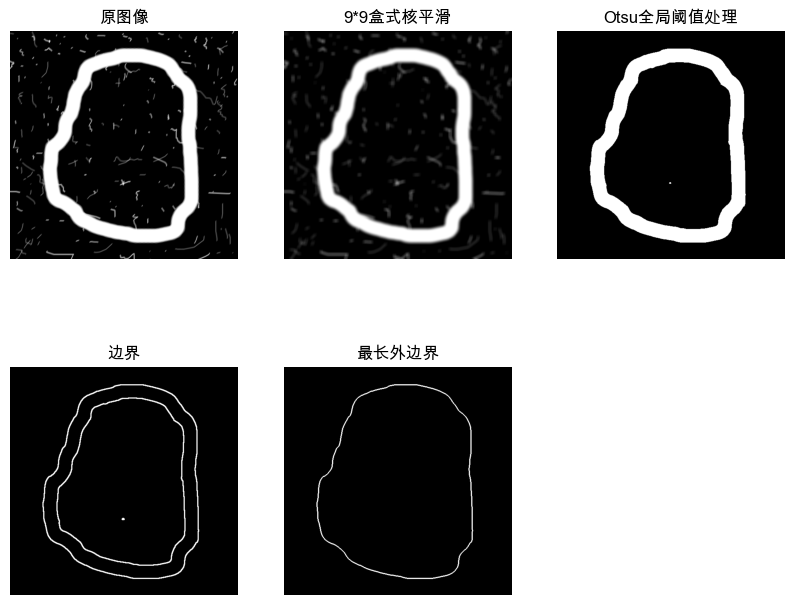

In [6]:
plt.figure(figsize=(10,8))
plt.subplot(231),plt.imshow(img,'gray'),plt.axis('off'),plt.title('原图像')
plt.subplot(232),plt.imshow (blur,'gray'),plt.title('9*9盒式核平滑'),plt.axis('off')
plt.subplot(233),plt.imshow(binary,'gray'),plt.axis('off'),plt.title('Otsu全局阈值处理')
plt.subplot(234),plt.imshow(imgCnts,'gray'),plt.axis('off'),plt.title('边界')
plt.subplot(235),plt.imshow(maxContour,'gray'),plt.title('最长外边界'),plt.axis('off')
# plt.subplot(236),plt.imshow(subPoints,'gray'),plt.axis('off'),plt.title('边界重采样')

(<Axes: title={'center': 'MMP'}>,
 (-0.5, 565.5, 565.5, -0.5),
 Text(0.5, 1.0, 'MMP'))

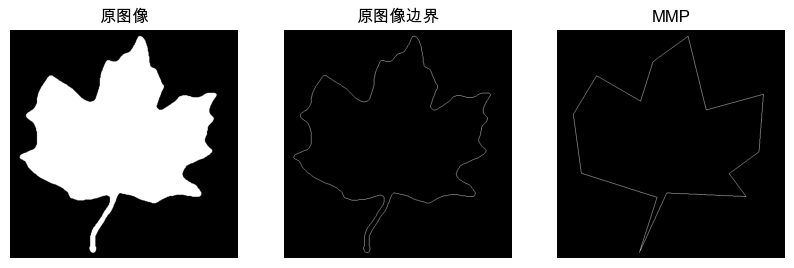

In [7]:
'''近似多边形拟合'''
#读取枫叶图像
img = cv2.imread('/Users/chenyuntao/Desktop/PyL/DIP/imageset/mapleleaf.tif',0)
#得到图像的边界
contours,hierarchy = cv2.findContours(img ,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
'''src 原图
cv2.RETR_TREE：提取轮廓后，输出轮廓信息的组织形式，除了cv2.RETR_TREE还有以下几种选项：
cv2.RETR_EXTERNAL：输出轮廓中只有外侧轮廓信息；
cv2.RETR_LIST：以列表形式输出轮廓信息，各轮廓之间无等级关系；
cv2.RETR_CCOMP：输出两层轮廓信息，即内外两个边界（下面将会说到contours的数据结构）；

cv2.CHAIN_APPROX_SIMPLE：指定轮廓的近似办法，有以下选项：
cv2.CHAIN_APPROX_NONE：存储轮廓所有点的信息，相邻两个轮廓点在图象上也是相邻的；
cv2.CHAIN_APPROX_SIMPLE：压缩水平方向，垂直方向，对角线方向的元素，只保留该方向的终点坐标；
cv2.CHAIN_APPROX_TC89_L1：使用teh-Chinl chain 近似算法保存轮廓信息。
'''
#OpenCV 中的函数 cv.approxPolyDP() 可以用于对图像轮廓点进行多边形拟合。
dst = np.zeros(img.shape,dtype=float)
boundary = cv2.drawContours(dst , contours , contourIdx= -1,color= 255, thickness=1)
contours = np.squeeze(contours)
approxCurve = cv2.approxPolyDP(contours , 32, True) #得到多边形的顶点序列
'''
cv2.approxPolyDP(curve, epsilon, closed[, approxCurve=None]) → approxCurve
cnt: [x,1,2]list列表
epsilon Douglas-Peucker算法参数
True 参数3表示是否闭合
'''
#利用polylines函数连接各点
dst = np.zeros(img.shape,dtype=float)
cv2.polylines(dst, [approxCurve], True, 255, 1)
'''
polylines(img, pts, isClosed, color, thickness=None, lineType=None, shift=None)
参数：
img（array）：为ndarray类型（可以为cv.imread）直接读取的数据
pts（array）：为所画多边形的顶点坐标，举个简单的例子：当一张图片需要有多个四边形时，该数组ndarray的shape应该为（N，4，2）
isClosed（bool）：所画四边形是否闭合，通常为True
color（tuple）：BGR三个通道的值
thickness（int）：画线的粗细
shift：顶点坐标中小数的位数
'''

plt.figure(figsize=(10,8))
plt.subplot(131),plt.imshow(img,'gray'),plt.axis('off'),plt.title('原图像')
plt.subplot(132),plt.imshow (boundary,'gray'),plt.title('原图像边界'),plt.axis('off')
plt.subplot(133),plt.imshow(dst,'gray'),plt.axis('off'),plt.title('MMP')


(<Axes: title={'center': '图2的标记图'}>,
 Text(0.5, 1.0, '图2的标记图'))

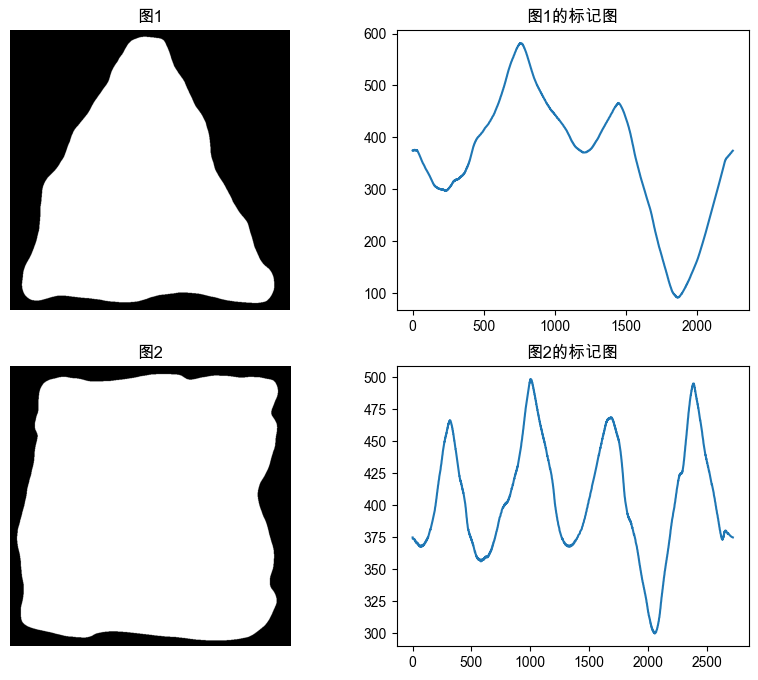

In [8]:
'''标记图'''
from scipy.spatial.distance import euclidean   #欧式距离
import numpy as np
import cv2


def get_centroid(img: np.ndarray):
    """给定一张图，返回其亮点的质心
    """
    white_point = np.where([img == 255])
    x = white_point[1].mean()
    y = white_point[2].mean()

    return x, y


def get_mark_sheet(img):
    img = img.astype(np.uint8)
    """根据图像返回标记图
    """
    #结果
    distance_list = []
    '''获取质心'''
    centroid = get_centroid(img)
    '''获取边界'''
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    contour = contours[0] #最外圈边界
    contour = np.squeeze(contour)
    '''距离list'''
    for point in contour:
        dist = euclidean(centroid, point)
        distance_list.append(dist)
    return distance_list

img1 = cv2.imread('/Users/chenyuntao/Desktop/PyL/DIP/imageset/distorted-triangel.tif',0)
img1 = np.array(img1,dtype=float)
img2 = cv2.imread('/Users/chenyuntao/Desktop/PyL/DIP/imageset/distorted-square.tif',0)
img2 = np.array(img2,dtype=float)
distances1 = get_mark_sheet(img1)
distances2 = get_mark_sheet(img2)

plt.figure(figsize=(10,8))
plt.subplot(221),plt.imshow(img1,'gray'),plt.axis('off'),plt.title('图1')
plt.subplot(222),plt.plot(distances1),plt.title('图1的标记图')
plt.subplot(223),plt.imshow (img2,'gray'),plt.title('图2'),plt.axis('off')
plt.subplot(224),plt.plot(distances2),plt.title('图2的标记图')


(<Axes: title={'center': '距离变换'}>,
 Text(0.5, 1.0, '距离变换'),
 (-0.5, 453.5, 453.5, -0.5))

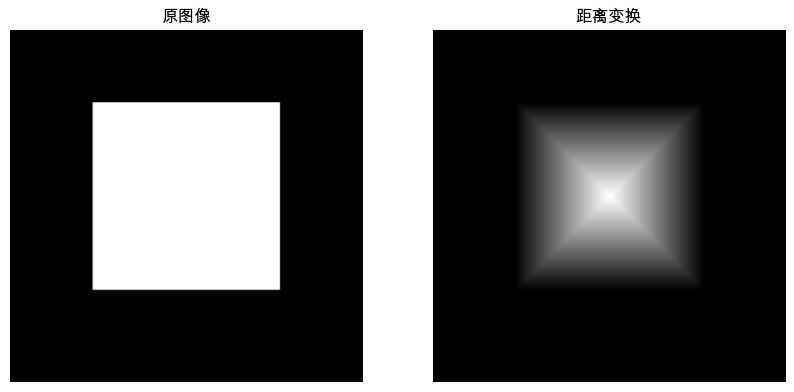

In [9]:
'''骨架、中轴、距离变换'''
import cv2
img = cv2.imread('/Users/chenyuntao/Desktop/PyL/DIP/imageset/wingding-square-solid.tif',0)

dist = cv2.distanceTransform(img,cv2.DIST_L2,maskSize=3)
'''src：输入的图像，一般为二值图像
distanceType：所用的求解距离的类型，有CV_DIST_L1, CV_DIST_L2（欧式距离） , or CV_DIST_C
mask_size：距离变换掩模的大小，可以是 3 或 5。对 CV_DIST_L1 或 CV_DIST_C 的情况，参数值被强制设定为 3, 因为 3×3 mask 给出 5×5 mask 一样的结果，而且速度还更快。
'''
plt.figure(figsize=(10,8))
plt.subplot(121),plt.imshow(img,'gray'),plt.axis('off'),plt.title('原图像')
plt.subplot(122),plt.imshow (dist,'gray'),plt.title('距离变换'),plt.axis('off')

In [10]:
from skimage import morphology
img = cv2.imread('/Users/chenyuntao/Desktop/PyL/DIP/imageset/blood-vessels.tif',0)

#细化运算得到骨架
def skeleton_extraction(img):
    '''骨架抽取算法'''
    skeleton = np.zeros(img.shape,dtype=np.uint8)                # 将结果保留在这
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))  # 3*3 方形结构元
 
    while img.any():     # 循环迭代
 
        img_open = cv2.dilate(cv2.erode(img,kernel),kernel)       # 做开运算
        # img_open = cv2.morphologyEx(img,cv2.MORPH_OPEN,kernel)  #OpenCV 形态学开运算方法

        img_diff = img - img_open                                   # 原图 - 开运算图
        skeleton = np.logical_or(skeleton,img_diff)                 # 将结果并在一起
        img = cv2.erode(img,kernel)                                 # 腐蚀
 
    return skeleton

ske1 = skeleton_extraction(img)
ske1 = np.array(ske1,dtype = float)
#阈值处理
ret, ske1 = cv2.threshold(ske1,0, 1, cv2.THRESH_BINARY)
img1 = np.copy(img)
img1[ske1 == 1.0] = 0

#使用Skimage库的骨架提取算法
ske2 = morphology.skeletonize(img)
ske2 = np.array(ske2,dtype = float)
#阈值处理
ret, ske2 = cv2.threshold(ske2,0, 1, cv2.THRESH_BINARY)
img2 = np.copy(img)
img2[ske1 == 1.0] = 0

#通过距离变换的方法得到骨架
def local_maximum(x):   # 取局部最大值  这里是4邻域
    dst = np.zeros(x.shape, dtype=np.uint8)     # 处理的结果存在dst中
    height,width = x.shape[:2]
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if x[i][j] != 0:
                if (x[i][j] >= x[i - 1][j]) and (x[i][j] >= x[i + 1][j]) and (x[i][j] >= x[i][j - 1]) and (x[i][j] >= x[i][j + 1]):
                    dst[i][j] = 255
    return dst

dist_trans = cv2.distanceTransform(img,cv2.DIST_L2,maskSize=3)

img_dst = cv2.normalize(dist_trans, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)  # 归一化,为了方便显示
 
ret = local_maximum(img_dst)    # 取距离变换后的局部最大值


#阈值处理
ret, ske3 = cv2.threshold(ret,0,1, cv2.THRESH_OTSU)
img3 = np.copy(img)
img3[ske3 == 1.0] = 0

(<Axes: title={'center': '距离变换提取的骨架'}>,
 Text(0.5, 1.0, '距离变换提取的骨架'),
 (-0.5, 868.5, 631.5, -0.5))

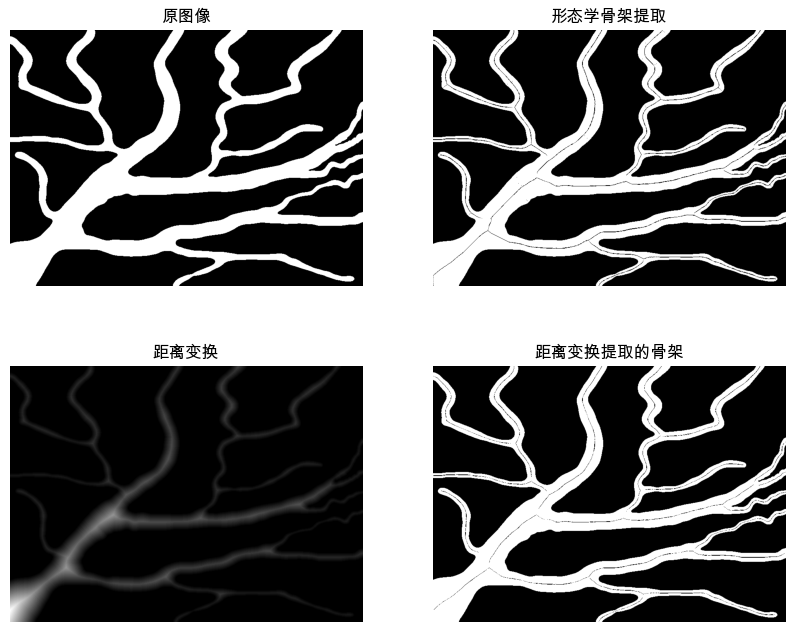

In [11]:
plt.figure(figsize=(10,8))
plt.subplot(221),plt.imshow(img,'gray'),plt.axis('off'),plt.title('原图像')
plt.subplot(222),plt.imshow (img1,'gray'),plt.title('形态学骨架提取'),plt.axis('off')
plt.subplot(223),plt.imshow (dist_trans,'gray'),plt.title('距离变换'),plt.axis('off')
plt.subplot(224),plt.imshow (img3,'gray'),plt.title('距离变换提取的骨架'),plt.axis('off')

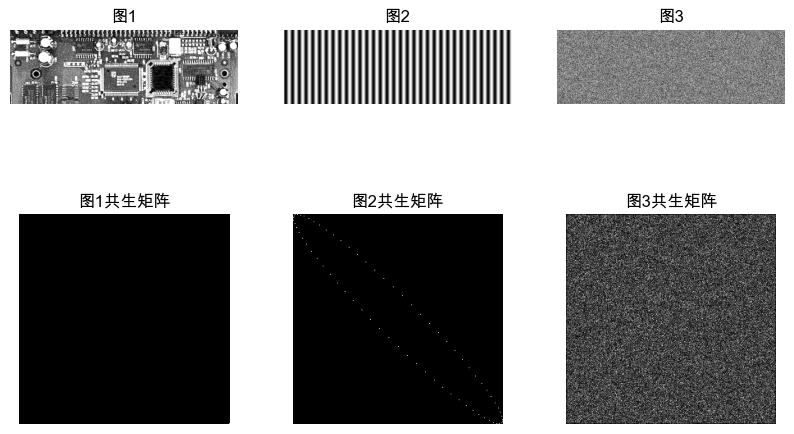

In [12]:
'''共生矩阵'''
from skimage.feature import graycomatrix, graycoprops

gray = cv2.imread("/Users/chenyuntao/Desktop/PyL/DIP/imageset/strip-2Dsinusoidal-waveform.tif",0)
# gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)  # 灰度图像
glcm1 = graycomatrix(gray,[1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)  # 灰度级 L=256
glcm1 = glcm1 / (263*800)   #归一化共生矩阵
#0度方向，距离为1的灰度共生矩阵
glcm10 = glcm1[:,:,0,0]


img2 = cv2.imread("/Users/chenyuntao/Desktop/PyL/DIP/imageset/texture-cktborad.tif",0)
img3 = cv2.imread("/Users/chenyuntao/Desktop/PyL/DIP/imageset/strip-uniform-noise.tif",0)
glcm2 = graycomatrix(img2,[1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)  # 灰度级 L=256
glcm2 = glcm2 / (263*800)
#0度方向，距离为1的灰度共生矩阵
glcm20 = glcm2[:,:,0,0]

glcm3 = graycomatrix(img3,[1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)  # 灰度级 L=256
glcm3 = glcm3 / (263*800)   #归一化共生矩阵
#0度方向，距离为1的灰度共生矩阵
glcm30 = glcm3[:,:,0,0]

plt.figure(figsize=(10,6))
plt.subplot(231),plt.imshow(img2,'gray'),plt.axis('off'),plt.title('图1')
plt.subplot(232),plt.imshow (gray,'gray'),plt.title('图2'),plt.axis('off')
plt.subplot(233),plt.imshow (img3,'gray'),plt.title('图3'),plt.axis('off')
plt.subplot(234),plt.imshow (glcm20,'gray'),plt.title('图1共生矩阵'),plt.axis('off')
plt.subplot(235),plt.imshow (glcm10,'gray'),plt.title('图2共生矩阵'),plt.axis('off')
plt.subplot(236),plt.imshow (glcm30,'gray'),plt.title('图3共生矩阵'),plt.axis('off')

#计算描述子

L1 = []
contrast1 = graycoprops(glcm2,'contrast')
L1.append(contrast1[:,0][0])
correlation1 = graycoprops(glcm2,'correlation')
L1.append(correlation1[:,0][0])
energy1 = graycoprops(glcm2,'energy')
L1.append(energy1[:,0][0])
homogeneity1 = graycoprops(glcm2,'homogeneity')
L1.append(homogeneity1[:,0][0])
L2 = []
contrast2 = graycoprops(glcm1,'contrast')
L2.append(contrast2[:,0][0])
correlation2 = graycoprops(glcm1,'correlation')
L2.append(correlation2[:,0][0])
energy2 = graycoprops(glcm1,'energy')
L2.append(energy2[:,0][0])
homogeneity2 = graycoprops(glcm1,'homogeneity')
L2.append(homogeneity2[:,0][0])
L3 = []
contrast3 = graycoprops(glcm3,'contrast')
L3.append(contrast3[:,0][0])
correlation3 = graycoprops(glcm3,'correlation')
L3.append(correlation3[:,0][0])
energy3 = graycoprops(glcm3,'energy')
L3.append(energy3[:,0][0])
homogeneity3 = graycoprops(glcm3,'homogeneity')
L3.append(homogeneity3[:,0][0])


In [19]:
import pandas as pd
data = {'描述子': ['对比度', '相关性', '熵', '同质性'],
        '图1': L1,
        '图2':L2,
        '图3':L3}
df = pd.DataFrame(data)
display(df.T)

,0,1,2,3
描述子,对比度,相关性,熵,同质性
图1,1044.075275,0.904275,0.059962,0.139768
图2,569.873592,0.964976,0.111122,0.030988
图3,10838.311682,-0.000473,0.004483,0.012246
